In [1]:
## invasive species deep learning from kernels on kaggle

In [2]:
ls

data/                   __MACOSX/   sample_submission.csv      submit.csv
Invasive_Species.ipynb  ReadMe.txt  sample_submission.csv.zip


In [2]:
import pandas as pd
import numpy as np
import os
from skimage import io, transform
import matplotlib.pyplot as plt
%matplotlib inline
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')

Using TensorFlow backend.


In [3]:
pd.read_csv('./data/train/train_labels.csv')

,name,invasive
0,1,0
1,2,0
2,3,1
3,4,0
4,5,1
5,6,0
6,7,1
7,8,1
8,9,0
9,10,0


In [4]:
trainpath = './data/train/'
testpath = './data/test/'
print('# of training files: ' + str(len(os.listdir(trainpath))))
print('# of testing files: ' + str(len(os.listdir(testpath))))

# of training files: 2300
# of testing files: 1533


In [5]:
# Preview labels
train_labels = pd.read_csv('./data/train/train_labels.csv')
print(train_labels.head())

   name  invasive
0     1         0
1     2         0
2     3         1
3     4         0
4     5         1


Non-Invasive image example./data/train/1.jpg (Height:866 Width:1154)
Non-Invasive image example./data/train/2.jpg (Height:866 Width:1154)
Non-Invasive image example./data/train/4.jpg (Height:866 Width:1154)
Non-Invasive image example./data/train/6.jpg (Height:866 Width:1154)
Non-Invasive image example./data/train/9.jpg (Height:866 Width:1154)
Non-Invasive image example./data/train/10.jpg (Height:866 Width:1154)


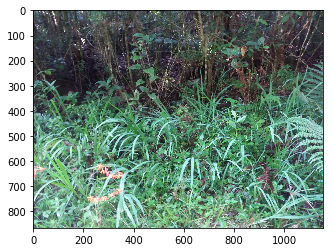

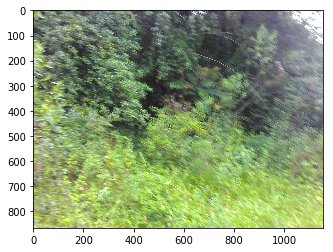

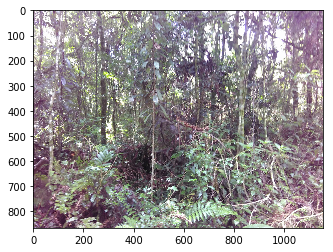

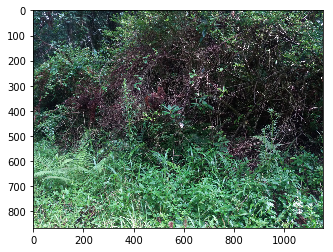

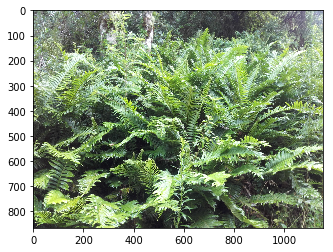

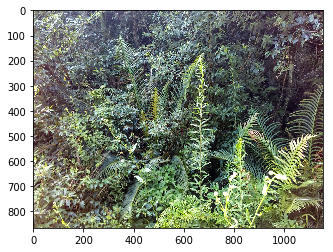

In [6]:
# Preview a few noninvasive plant images
for i in range(12):
#    print(train_labels.name[i], train_labels.invasive[i])
    sample_image = io.imread(trainpath + str(train_labels.name[i]) + '.jpg')
    if train_labels.invasive[i] < 1:
        print('Non-Invasive image example' + trainpath + str(train_labels.name[i]) + '.jpg (Height:{0} Width:{1})'.format(sample_image.shape[0], sample_image.shape[1]))
        plt.figure()
        plt.imshow(sample_image)

Invasive image example./data/train/3.jpg (Height:866 Width:1154)
Invasive image example./data/train/5.jpg (Height:866 Width:1154)
Invasive image example./data/train/7.jpg (Height:866 Width:1154)
Invasive image example./data/train/8.jpg (Height:866 Width:1154)
Invasive image example./data/train/11.jpg (Height:866 Width:1154)
Invasive image example./data/train/12.jpg (Height:866 Width:1154)


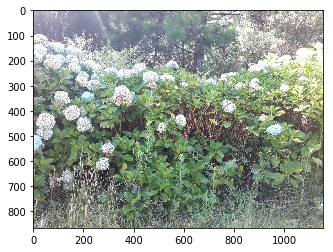

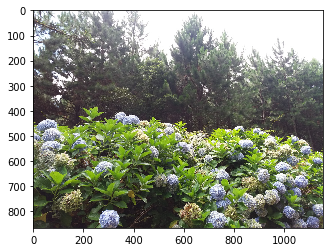

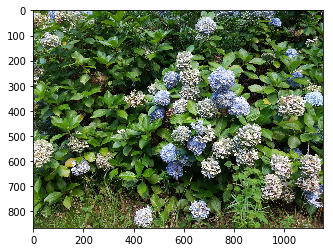

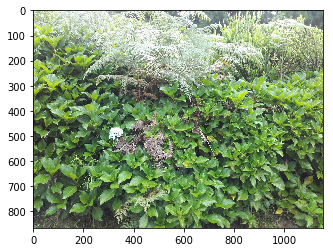

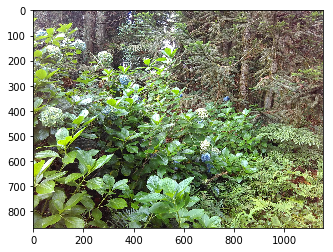

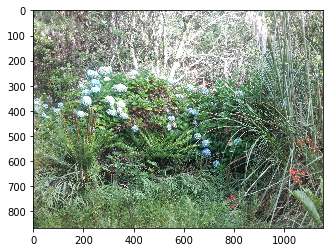

In [7]:
# Preview a few invasive plant images

for i in range(12):
#    print(train_labels.name[i], train_labels.invasive[i])
    sample_image = io.imread(trainpath + str(train_labels.name[i]) + '.jpg')
    if train_labels.invasive[i] > 0:
        print('Invasive image example' + trainpath + str(train_labels.name[i]) + '.jpg (Height:{0} Width:{1})'.format(sample_image.shape[0], sample_image.shape[1]))
        plt.figure()
        plt.imshow(sample_image)

In [ ]:
# Kernel memory is limited so I'm using 100 images each for training and validation 
# and scaling them down to 150x200 pixels to keep things simple.
xpix = 150
ypix = 200
ncol = 3
scaled = (xpix, ypix, ncol)
n_train = 2300
x_train = np.empty(shape=(n_train, xpix, ypix, ncol))
y_train = np.array(train_labels.invasive.values[0:n_train])
n_eval = 50
x_val = np.empty(shape=(n_eval, xpix, ypix, ncol))
y_val = np.array(train_labels.invasive.values[n_train:n_train+n_eval])

for i in range(n_train):
    tr_im = io.imread(trainpath + str(i+1) + '.jpg')
    x_train[i] = transform.resize(tr_im, output_shape=scaled)

for i in range(n_eval):
    val_im = io.imread(trainpath + str(i+n_train+1) + '.jpg')
    x_val[i] = transform.resize(val_im, output_shape=scaled)

In [ ]:
# Starting architecture
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Flatten, Dense, Dropout
from keras.optimizers import SGD

model = Sequential()
model.add(ZeroPadding2D((1, 1), input_shape=(150, 200, 3)))

model.add(Convolution2D(64, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(64, 3, 3, activation='relu'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

#model.add(ZeroPadding2D((1, 1)))
#model.add(Convolution2D(128, 3, 3, activation='relu'))
#model.add(ZeroPadding2D((1, 1)))
#model.add(Convolution2D(128, 3, 3, activation='relu'))
#model.add(MaxPooling2D((2, 2), strides=(2, 2)))

#model.add(ZeroPadding2D((1, 1)))
#model.add(Convolution2D(256, 3, 3, activation='relu'))
#model.add(ZeroPadding2D((1, 1)))
#model.add(Convolution2D(256, 3, 3, activation='relu'))
#model.add(ZeroPadding2D((1, 1)))
#model.add(Convolution2D(256, 3, 3, activation='relu'))
#model.add(MaxPooling2D((2, 2), strides=(2, 2)))

#model.add(ZeroPadding2D((1, 1)))
#model.add(Convolution2D(512, 3, 3, activation='relu'))
#model.add(ZeroPadding2D((1, 1)))
#model.add(Convolution2D(512, 3, 3, activation='relu'))
#model.add(ZeroPadding2D((1, 1)))
#model.add(Convolution2D(512, 3, 3, activation='relu'))
#model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=SGD(lr=1e-5, momentum=0.75, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Look at how tensors affect output shape
print(model.summary())

In [ ]:
# One epoch for demonstration purposes
model.fit(x_train, y_train, nb_epoch=200, batch_size=20)

In [ ]:
x_train.shape

In [ ]:
acc = model.evaluate(x_val, y_val)[1]
print('Evaluation accuracy:{0}'.format(round(acc, 4)))

In [ ]:
# reading test sample
sample_submission = pd.read_csv("sample_submission.csv")
img_path = "./data/test/"

test_names = []
file_paths = []

for i in range(len(sample_submission)):
    test_names.append(sample_submission.ix[i][0])
    file_paths.append( img_path + str(int(sample_submission.ix[i][0])) +'.jpg' )
    
test_names = np.array(test_names)

In [ ]:
sample_submission.head()

In [ ]:
test_images = []
for file_path in file_paths:
    #read image
    img = io.imread(file_path)
    img = transform.resize(img, output_shape=scaled)
    test_images.append(img)
    
    path, ext = os.path.splitext( os.path.basename(file_paths[0]) )

test_images = np.array(test_images)

In [ ]:
predictions = model.predict(test_images)

for i, name in enumerate(test_names):
    sample_submission.loc[sample_submission['name'] == name, 'invasive'] = predictions[i]

sample_submission.to_csv("submit.csv", index=False)

In [ ]:
pd.read_csv('submit.csv')